In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from PIL import Image

# Convolutional Neural Network Layers

Tensorflow has a lot of different types of layers which can be used to build convolutional neural networks. In thi tutorial we demonstrate the how each of the operators work, and how they can be applied to image processing. For this tutorial we will use this test image of a valve and explore the operation of the different building blocks on the CNN.

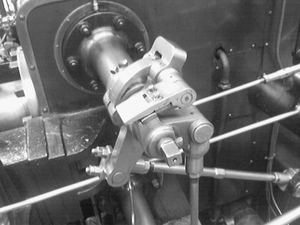

In [3]:
image = Image.open('data/valve.png').convert('LA')
image

The following code just converts to `PIL` image object to a numpy array, convert, makes sure that it is of type `float32`, and expand to be 4D: `(batch_size, height, width, channel)`.


In [6]:
mat = np.array(image)[..., :1]
mat = mat.astype(np.float32)
mat = mat[np.newaxis]
mat.shape

(1, 225, 300, 1)

## Convolution Operator

This example shows how the convolution operator works in Tensorflow. Here we're hard coding the kernel to the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator), which can be used to highlight edges in an image. Normally, we would learn the values of the kernel via backpropagation instead of hand coding them directly. 

**Exercise**: Try changing the parameters of the convolution. What affect does this have on the output?
 1. Change the number of filters.
 2. Change the kernel size.
 3. Change the number of strides.
 4. Change the dilation rate.


In [13]:
def sobel_kernel(shape, dtype):
    """Initialise the kernel to the Sobel horizontal operator"""
    
    kernel = np.array([
      [+1, 0, -1],
      [+2, 0, -2],
      [+1, 0, -1],
    ])

    return kernel.reshape(shape)
  
conv_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', dilation_rate=1, 
                                    kernel_initializer=sobel_kernel)
out = conv_layer(mat)  # Apply conv layer to image

out = np.squeeze(out)  # Get rid of the first and last dimensions
out = np.absolute(out) # Convert response to magnitude
out = np.uint8(out)    # Convert to int for visualization
out.shape

(225, 300)

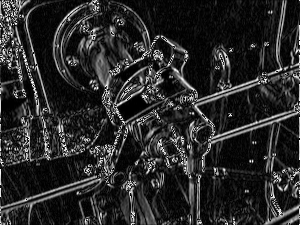

In [14]:
Image.fromarray(out)

## MaxPooling Operator

The max pooling operator takes an input and chooses the maximum of each non-overlapping patch as the value for the next image. This essentially results in a crude downsampling of the whole image.

**Exercise**: Try changing the `pool_size` parameter. What effect does this have on the output?

In [16]:
max_pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
out = max_pool_layer(mat)

out = np.squeeze(out)
out = np.uint8(out)
out.shape

(112, 150)

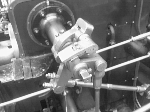

In [17]:
Image.fromarray(out)

## Upsampling2D

The UpSampling2D layer can be used to upsample an input by a given factor. This is can often be useful in decoder networks that transfrom from a latent space back to an image.

**Exercise**: Try changing the parameters of the up sampling layer. How this this affect the output?
1. Change the size parameter. What happens if you make the height and width different numbers?
2. Change the interpolation type. Consult the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D) for the other valid values... 


In [13]:
conv_trans_layer = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')
out_trans = conv_trans_layer(mat)

out_trans = np.squeeze(out_trans)
out_trans = np.uint8(out_trans)
out_trans.shape

(450, 600)

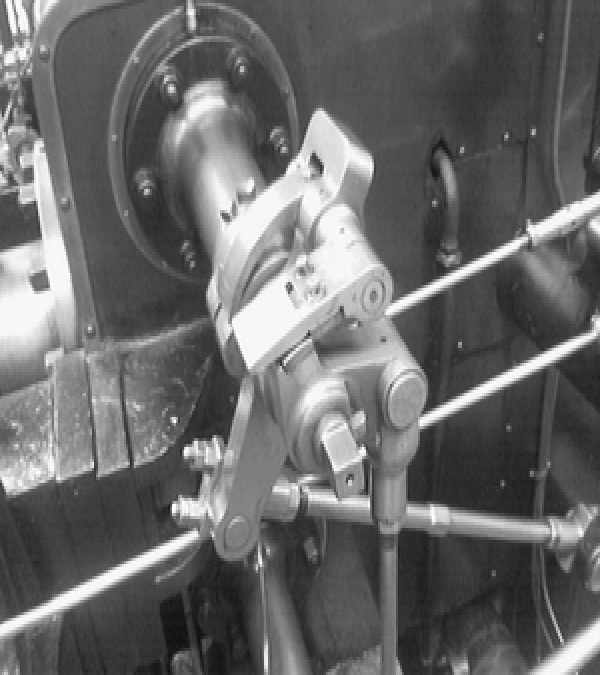

In [12]:
Image.fromarray(out_trans)

## Transpose Convolution

This is an example of using transpose convolutions to upsample images. Unlike `UpSampling2D` layers, the transformation kernel from input to output is not pre-defined asn is learned via back propagation. For this example we have initialised the kernel matrix by hand to a simple Gaussian kernel, which will smoothly upsample the image.

**Exercise**: Try chaning the parameters for the transpose convolution

1. Change the kernel size
2. Change the strides
3. Change the no. of filters
4. Change or remove the `kernel_initializer`
5. What happens if we set `kernel_size=3` and `stides=2`? 

In [78]:
def gaussian_kernel(shape, dtype):
    """Initialise the kernel to the Gaussian matrix"""
    nsig = 1
    kernlen = shape[0]
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    kernel = kern2d/kern2d.sum()
    return kernel.reshape(shape)

conv_trans_layer = tf.keras.layers.Conv2DTranspose(kernel_size=4, strides=2, filters=1, kernel_initializer=gaussian_kernel)
out_trans = conv_trans_layer(mat)

out_trans = np.squeeze(out_trans)
# Normalise the outputs back to the 0-255 range
out_trans = (out_trans - out_trans.min()) / (out_trans.max() - out_trans.min()) * 255
out_trans = np.uint8(out_trans)
out_trans.shape

(452, 602)

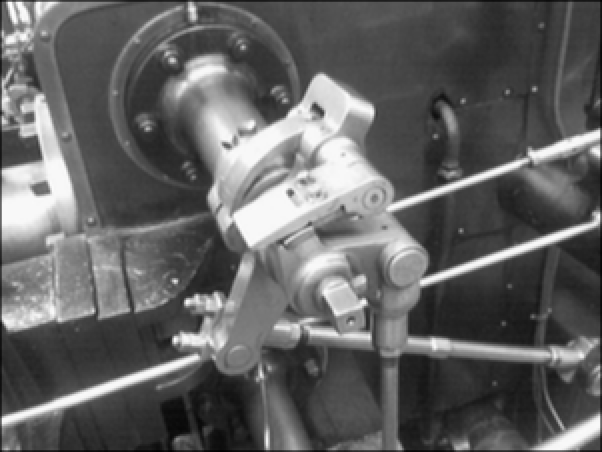

In [77]:
Image.fromarray(out_trans)